---
## 1. Get the data

**Download the data by executing the code below:**

`Notes:`
* This script will download all PDF files from an AWS S3 bucket, maintaining the directory structure, and store them in a DataFrame.
* Ensure you have the necessary AWS credentials and configurations set in a .env file.
* The script uses boto3 to interact with S3, pandas to handle the data, and re for string manipulation.
* The script first downloads all PDF files, then filters these files to obtain those with the most recent and oldest years per company.
* Finally, it extracts the content of the filtered PDFs using the LlamaParse library.
* The extracted content is stored in a new DataFrame, which includes the PDF file names and their corresponding text content.


In [2]:
# Importing the necessary libraries
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from src.plots import(
  analyze_text,
  analyze_sentiment,
  generate_word_cloud,
  plot_common_words,
  display_ngrams_with_plot_side_by_side
)

In [3]:
from src import data_utils

# From the notebook, set the variable to choose the method and call the function
USE_LLAMAPARSE = False  # or False to use fitz
LLAMAPARSE_API_KEY = os.getenv("LLAMAPARSE_API_KEY")

# Call the function to download the PDFs
filtered_pdfs_df = data_utils.download_pdfs_and_convert_to_text(use_llamaparse=USE_LLAMAPARSE, llamaparse_api_key=LLAMAPARSE_API_KEY)


## 2. Normalize the data

**Normalizing text is crucial for preparing data for further analysis, ensuring the text is consistent and easy to process by removing noise and standardizing the format.**

- **Text Cleaning (`clean_text`):** Convert text to lowercase, remove unwanted characters such as punctuation, URLs, HTML tags, and digits.
- **Expand Contractions (`expand_contractions`):** Replace contractions (e.g., "can't" to "cannot") using a predefined dictionary of contractions.
- **Lemmatize Text (`lemmatize_text`):** Tokenize the text and apply lemmatization to convert words to their base form (e.g., "running" to "run").
- **Remove Stopwords (`remove_stopwords`):** Tokenize the text and remove common stop words that do not contribute to the meaning (e.g., "and", "the").
- **Normalize Corpus (`normalize_corpus`):** Combine text chunks into a single string if needed, apply text cleaning, contraction expansion, lemmatization, and stop word removal in sequence, save the cleaned and processed text to a `.txt` file with a specified prefix, and return the normalized text and the output file name.


In [4]:
from src import text_normalizer

# Text cleanup and normalization
cleaned_text = text_normalizer.normalize_corpus(filtered_pdfs_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Exploratory Data Analysis (EDA)**

1. Number of Words in the Vocabulary

In [5]:
# Call the analyze_text function
X, num_words, vocab_sample = analyze_text(cleaned_text)

print("Number of words in the vocabulary:", num_words)
print("Words in the vocabulary:", vocab_sample)

Number of words in the vocabulary: 31520
Words in the vocabulary: ['4371', '7338639', 'rofo', 'restrain', '1654', '9618', '1213508', '2313', 'staff', 'partner']


2. Sentiment of the Text

In [6]:
sentiment = analyze_sentiment(cleaned_text)
print(f"Sentiment of the text: Polarity={sentiment.polarity}, Subjectivity={sentiment.subjectivity}")

Sentiment of the text: Polarity=0.06554139184961945, Subjectivity=0.36751764105248313


3. Word Cloud

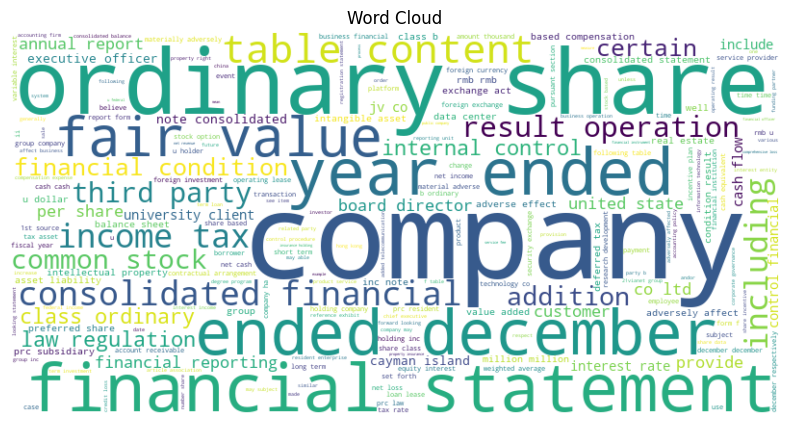

In [7]:
generate_word_cloud(cleaned_text)

4. Common Words Frequency

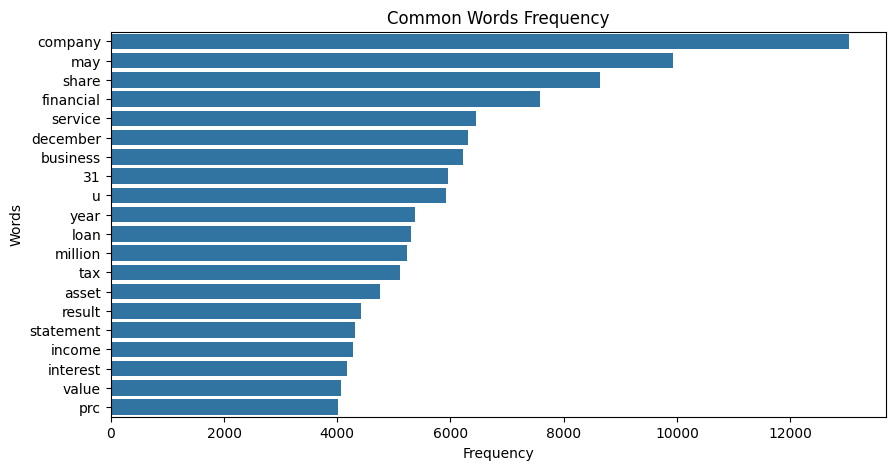

In [8]:
plot_common_words(cleaned_text)

5. Top 10 Bigrams

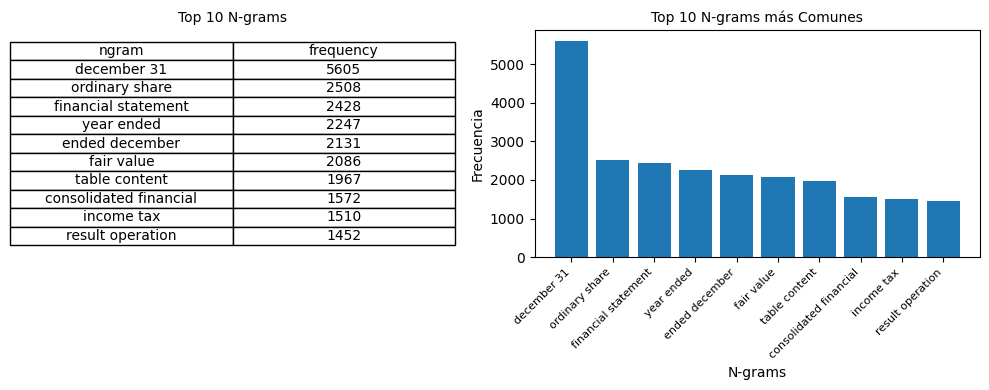

In [9]:
display_ngrams_with_plot_side_by_side(cleaned_text, n=2, top_n=10)

---
## 3. Feature Engineering

In this stage, we have split the texts into fragments and vectorized them so that the machine learning models can understand them. We used the `CharacterTextSplitter` class from LangChain to divide the long texts into more manageable fragments, ensuring that each fragment retains enough context.

After splitting the texts, we store the fragments in a new column of the DataFrame. Then, we use OpenAI embeddings to convert these text fragments into numerical vectors. Embeddings are numerical representations that capture the semantics and context of the texts.

Finally, we store these vectors in a `VectorStore` using FAISS, a library for searching and storing large amounts of vectors. This will allow us to search and retrieve similar text fragments quickly and efficiently.


In [10]:
import os
from src import text_processing

# Create and save the vectorstore
text_processing.create_and_save_vectorstore(cleaned_text)

## 4. Ragas Evaluation

`ragas` is a library designed for evaluating the performance of question-answering (QA) systems. It provides various metrics to measure the quality of answers generated by these systems. The metrics help in assessing aspects such as the relevance of the answer, faithfulness to the context, precision, recall, correctness, and similarity of the answer.

When this code is executed:

* A dataset will be loaded from a JSON file.
* A set of evaluation metrics will be defined to measure different aspects of the QA system's performance.
* The dataset will be evaluated using the specified metrics.
* The evaluation results will be processed into two DataFrames: one for the global results and one for the results by question.
* The processed results will be returned for analysis or visualization.

In [36]:
from src import ragas_utils
from src import ragas_model

# Read information questions.txt
data_questions = ragas_utils.process_information()

# Process model for add answer and contexts
template = ''''''
data_ragas = ragas_model.execute(data_questions, template)

# Create data.json
ragas_utils.create_ragas_data_file(data_ragas)

The data.json file was created successfully


In [37]:
from src import ragas_evaluate

#Evaluation
global_result, question_result = ragas_evaluate.get_evaluation()

Generating train split: 10 examples [00:00, 830.52 examples/s]
Evaluating: 100%|██████████| 60/60 [00:22<00:00,  2.65it/s]


In [38]:
global_result

,Result
context_precision,0.900000
faithfulness,0.900000
answer_relevancy,0.781460
context_recall,0.700000
answer_correctness,0.424819
answer_similarity,0.949281


In [30]:
question_result

,question,answer,contexts,ground_truth,context_precision,faithfulness,answer_relevancy,context_recall,answer_correctness,answer_similarity
0,"What were 1-800-Flowers.com, Inc.'s 2019 tot...","1-800-Flowers.com, Inc.'s 2019 total net reven...",[r v n g g r w h b u l n g e n u 2019 annual r...,"1-800-Flowers.com, Inc.'s 2019 total net reve...",0.805556,1.0,0.973966,1.0,0.247091,0.988365
1,"What was 1-800-Flowers.com, Inc.'s gross prof...","1-800-Flowers.com, Inc.'s gross profit margin ...",[within corporate overhead asset liability net...,"As of July 2019, 1-800-Flowers.com, Inc.'s gr...",1.000000,0.0,0.983010,1.0,0.995184,0.980734
2,"What were 1-800-Flowers.com, Inc.'s net reven...",I don't have the information on 1-800-Flowers....,[r v n g g r w h b u l n g e n u 2019 annual r...,"In 2021, 1-800-Flowers.com, Inc.'s net revenu...",0.333333,0.0,0.000000,0.0,0.220126,0.880503
3,"What was 1-800-Flowers.com, Inc.'s cost of re...",I don't have that specific information based o...,[1-800-flowerscom inc letter shareholder dear ...,"In 2022, 1-800-Flowers.com, Inc.'s cost of re...",0.833333,0.0,0.000000,0.0,0.172455,0.689820
4,What was the net loss attributable to the com...,The net loss attributable to the company's ord...,[loss 20 65754 24236 3741 statutory reserve 52...,The net loss attributable to the company's or...,0.916667,1.0,0.984307,1.0,0.619729,0.978914
5,"What were 21Vianet Group, Inc.'s net intangib...","21Vianet Group, Inc.'s net intangible assets i...",[share additional paid-in capital accumulated ...,"21Vianet Group, Inc.'s net intangible assets ...",1.000000,0.0,0.983191,1.0,0.247252,0.988999
6,"What were 2U, Inc.'s total costs and expenses...","2U, Inc.'s total costs and expenses in 2019 we...",[statement 69 2u inc consolidated statement op...,"In 2019, 2U, Inc.'s total costs and expenses ...",0.500000,1.0,0.977625,0.0,0.240560,0.962240
7,What were the Companyâ€™s cash interest payme...,"The Company's cash interest payments for 2022,...",[service debt year ended december 31 2022 2021...,The Companyâ€™s cash interest payments were $...,1.000000,1.0,0.980295,1.0,0.241241,0.964962
8,What were the total loans and leases for 2022...,"The total loans and leases for 2022 were $6,01...",[2022 2021 asset cash due bank 84703 54420 fed...,"The total loans and leases were $6,011,162 fo...",1.000000,1.0,0.981202,1.0,0.742715,0.970859
9,What was the cost of revenue for 2019 and 2017?,"The cost of revenue for 2019 was RMB 61033, an...",[increased future tax liability u 87 table con...,"The cost of revenue was $61,033 in 2019 and $...",1.000000,1.0,0.946667,1.0,0.227721,0.910889


In [20]:
filtered_pdfs_df

,name,content,year,base_name,text
0,NASDAQ_FLWS_2019.pdf,b'%PDF-1.6\r%\xe2\xe3\xcf\xd3\r\n1183 0 obj\r<...,2019.0,NASDAQ_FLWS,"D R I V I N G G R O W T H , \nB U I L D I N ..."
3,NASDAQ_FLWS_2022.pdf,b'%PDF-1.7\r%\xe2\xe3\xcf\xd3\r\n743 0 obj\r<<...,2022.0,NASDAQ_FLWS,"1-800-FLOWERS.COM, INC. \nLETTER TO SHAREHOLDE..."
4,NASDAQ_TXG_2019.pdf,b'%PDF-1.4\n%\xd3\xeb\xe9\xe1\n1 0 obj\n<</Cre...,2019.0,NASDAQ_TXG,Table of Contents\n \n \nUNITED STATES\nSECURI...
6,NASDAQ_TXG_2021.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2021.0,NASDAQ_TXG,Table of Contents\nUNITED STATES\nSECURITIES A...
7,NASDAQ_YI_2018.pdf,b'%PDF-1.4\n%\xe4\xe3\xcf\xd2\n1 0 obj\n[/PDF/...,2018.0,NASDAQ_YI,Table of Contents\n \nUNITED STATES\nSECURITIE...
10,NASDAQ_YI_2021.pdf,b'%PDF-1.7\n%\x81\x81\x81\x81\n\n8 0 obj\n<<\n...,2021.0,NASDAQ_YI,Table of Contents\nUNITED STATES\n\nSECURITIES...
11,NASDAQ_PIH_2015.pdf,b'%PDF-1.6\r%\xe2\xe3\xcf\xd3\r\n505 0 obj\r<<...,2015.0,NASDAQ_PIH,"2015 Annual Report \nApril 29, 2016 \n \nFello..."
13,NASDAQ_PIH_2017.pdf,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,2017.0,NASDAQ_PIH,"\n \n \n \n \n \n \nApril 20, 2018 \n \nDear ..."
14,NASDAQ_BCOW_2021.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2021.0,NASDAQ_BCOW,Table of Contents\n \n \nUNITED STATES\nSECURI...
15,NASDAQ_BCOW_2022.pdf,b'%PDF-1.4\r\n%\xd3\xf4\xcc\xe1\r\n1 0 obj\r\n...,2022.0,NASDAQ_BCOW,\n \n \nUNITED STATES \nSECURITIES AND EXCH...
